In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re
import string
import math
import gensim.downloader as api
import sklearn
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import inflect
import contractions
from sklearn.feature_extraction.text import TfidfVectorizer

AND THOU WEEP AT THE LAST, AS THY BODY AND THY FLESH ARE CONSUMED

In [2]:
print("I hate them with perfect hatred; I count them my enemies.")

I hate them with perfect hatred; I count them my enemies.


Retrieve Data.

In [3]:
df = pd.read_excel("Dataset.xlsx")
questionList = df["Question"].unique()
answerList = df["Answer"]
# for answer in answerList:
#     print(answer)
# print("Answer list : {}".format(len(answerList)))
# print("Question list : {}".format(len(questionList)))

Preprocessing

In [4]:
# this function returns a list of tokens, cleaned and preprocessed. 
def preprocess_document(corpus, isLemma=False, isStopwords=False, isInflect=False, isNumberFiltered=True):   
   
   inflector = inflect.engine() # prepare inflector
   stop_words = set(stopwords.words("english"))
   lemmatizer = WordNetLemmatizer()
   punctuations = string.punctuation

   # if numbers are filtered, add that to the punctuation string
   if isNumberFiltered:
      punctuations += "1234567890"

   # case fold
   corpus = corpus.lower()

   # remove puncs
   corpus = "".join([char for char in corpus if char not in punctuations])

   # tokenize it.
   token_list = nltk.word_tokenize(corpus)

   for i in range(len(token_list)):
      # if inflect
      if isInflect:
         if token_list[i].isdigit():
            token_list[i] = inflector.number_to_words(token_list[i])

      # if lemma
      if isLemma:
         tagged_word = nltk.pos_tag([token_list[i]])
         wordnet_pos = get_wordnet_pos(tagged_word[0][1])
         token_list[i] = lemmatizer.lemmatize(tagged_word[0][0], pos=wordnet_pos)
      
      # if stopword
      if isStopwords:
         if token_list[i] in stop_words or token_list[i].isdigit():
            token_list[i] = "#" # mark as #
      
   # remove the marked strings
   token_list = [token for token in token_list if token != "#"]
   return token_list
            
def get_wordnet_pos(tag):
    """Map POS tag to WordNet POS tag"""
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN # solves as noun by default.

Get Word Set

In [5]:
def get_word_set(df):
    bigtext = ""
    # join in lower case
    for i in range(len(df)):
        bigtext += " {}".format(df[i].lower())
    bigtext = contractions.fix(bigtext) # remove contractions
    bigtext = "".join([char for char in bigtext if char not in string.punctuation]) # remove punctuations
    big_text_tokens = preprocess_document(bigtext, isLemma=True) # put in blender like dick
    return set(big_text_tokens) # return as set


my_word_set = get_word_set(df["Answer"])
print(len(my_word_set))
for word in my_word_set:
    print(word)

504
justice
very
grateful
contribute
picture
feel
mystery
up
heartbeat
subject
salvation
grave
value
obvious
teenager
legal
call
that
ready
parent
more
unicellular
capable
well
maybe
solution
accept
your
same
glorify
adult
effect
full
ability
statement
can
disagree
choose
count
revise
state
death
negative
output
amphibious
assault
context
error
usual
period
concept
right
moral
matter
prochoice
decision
evolution
accepted
grows
abuse
depends
no
everything
regardless
she
bad
data
time
section
themselves
holy
fun
impact
specie
image
others
intent
amongst
foolishness
hell
special
grace
either
form
example
them
fish
of
involve
imperfection
valuable
widely
mortal
bound
ideal
nary
base
take
therefore
her
sinful
sanction
difficulty
you
support
man
relationship
optimal
why
lead
go
view
give
law
already
bring
they
voluntarily
affect
pro
reckon
evolve
nowadays
come
science
say
big
would
imperfectly
sexual
decide
because
all
see
limitation
medical
consequence
government
life
existence
choice
evil


In [ ]:
# get all words
word_list = ""
for i in range(len(df)):
    word_list += " {}".format(df["Answer"][i])

word_list = word_list.lower()

word_list = contractions.fix(word_list)
    
# remove punctuations
corpus = "".join([char for char in word_list if char not in string.punctuation])

word_set = set()
for word in nltk.word_tokenize(corpus):
    word_set.add(corpus)
word_tokens = preprocess_document(word_list, isLemma=True)
word_set = set(word_tokens)
print(len(word_set))
for word in word_set:
    print(word)

TF-IDF function

In [5]:
# takes a bunch of documents and make a TF-IDF out of them. Returns a tf-idf matrix and a df as well
# this assumes the documents are ALREADY PREPROCESSED to avoid differences in preprocessing, therefore anachronism.
def get_tfidf(documents, isPreprocessed=True):
    if not isPreprocessed:
        documents = [preprocess_document(doc, isLemma=True, isStopwords=True) for doc in documents]
    flattened_documents = [' '.join(doc) for doc in documents]
    vectorizer = TfidfVectorizer()
    matrix = vectorizer.fit_transform(flattened_documents)
    tfidf_keys  = vectorizer.get_feature_names_out()
    df_tfidf = pd.DataFrame(matrix.toarray(), columns=tfidf_keys)

    return df_tfidf, matrix

Get TF-IDF matrix

In [47]:
my_tfidf, my_matrix = get_tfidf(df["Answer"], isPreprocessed=False)
my_tfidf
my_matrix

<72x434 sparse matrix of type '<class 'numpy.float64'>'
	with 774 stored elements in Compressed Sparse Row format>

Word and Sentence Embeddings

In [6]:
# load and use the word embedding
import gensim
import gensim.downloader as api
from nltk.test.gensim_fixt import setup_module
setup_module()

model = api.load('word2vec-google-news-300')

Functions to word- and sentence-embed a document

In [7]:
# embed the individual words of a document. takes a list of tokens and a w2v model, returns a list of tuples(word, 300d vector).
def word_embed(document, model):
    word_embed_pairs = []
    for word in document:
        if word in model:
            word_embed_pairs.append((word, model[word]))
    return word_embed_pairs

def sentence_embed_unweighted_doc(word_embed_pair_list, aggregateMethod="avg"):
    wvs = []
    for pair in word_embed_pair_list:
        wvs.append(pair[1])
    if aggregateMethod == "avg":
        return np.mean(wvs, axis=0)
    else:
        return np.sum(wvs, axis=0)

def sentence_embed_unweighted(word_embedded_docs, aggregateMethod="avg"):
    sentence_embedded_docs = []
    for i in range(len(word_embedded_docs)):
        sentence_embedded_docs.append(sentence_embed_unweighted_doc(word_embedded_docs[i], aggregateMethod))
    return sentence_embedded_docs

# embed the words into sentences with a preferred method. takes a list of tuples (word, 300d vector), a tfidf matrix, and an index. returns a 300d vector aggregated sentence with the preferred method.
def sentence_embed_weighted_doc(word_embed_pair_list, tfidf_matrix, index, aggregateMethod="avg"):
    weighted_wvs = []
    for pair in word_embed_pair_list:
        tfidf_weight = 0
        if pair[0] in tfidf_matrix:
            tfidf_weight = tfidf_matrix[pair[0]][index]
        weighted_wvs.append(pair[1] * tfidf_weight)

    weighted_wvs = np.array(weighted_wvs)
    if aggregateMethod == "avg":
        sentence_vector = np.mean(weighted_wvs, axis=0)
    else:
        sentence_vector = np.sum(weighted_wvs, axis=0)
    return sentence_vector

def sentence_embed_weighted(word_embedded_docs, tfidf_matrix, aggregateMethod="avg"):
    sentence_embedded_docs = []
    for i in range(len(word_embedded_docs)):
        sentence_embedded_docs.append(sentence_embed_weighted_doc(word_embedded_docs[i], tfidf_matrix, i, aggregateMethod))
    return sentence_embedded_docs
    

Embedding each document.

In [8]:
docs = [preprocess_document(doc, isLemma=True, isStopwords=True) for doc in df["Answer"]]
word_embedded_docs = []
for doc in docs:
    word_embedded_docs.append(word_embed(doc, model))

# sentence_embed("bababui", tfidf_matrix=my_tfidf, index=1)
doc_embeds = sentence_embed_weighted(word_embedded_docs, my_tfidf, "avg")

df["Document Embed"] = doc_embeds
print(len(docs))
sum = 0
for doc in docs:
    sum += len(doc)
print(sum)

NameError: name 'df' is not defined

The LDA Approach

In [9]:
# Remind me again how we can extract whole features from here?

# print(len(corpus_tfidf))
# sum = 0
# for thing in corpus_tfidf:
#     sum += len(thing)
# print(sum)
# # for i, doc_topic_dist in enumerate(doc_topic_distributions):
# #     print("Document", i+1)
# #     for topic_prob in doc_topic_dist:
# #         print("Topic {}: {}".format(topic_prob[0], topic_prob[1]))
# #     print("\n")

import gensim
from gensim import corpora, models
def LDA(docs, topic_prob):
    dictionary = corpora.Dictionary(docs) 
    corpus = [dictionary.doc2bow(doc) for doc in docs]
    tfidf = models.TfidfModel(corpus)
    corpus_tfidf = tfidf[corpus]
    lda_model = gensim.models.LdaModel(corpus_tfidf, num_topics=topic_prob, id2word=dictionary )
    doc_topic_distributions = lda_model[corpus]
    # view it...
    
    docFeatureList = []
    for doc_topic_dist in doc_topic_distributions:
        featureList = [0.0 for i in range(topic_prob)]
        for topic_dist in doc_topic_dist:
            featureList[topic_dist[0]] = topic_dist[1]
        docFeatureList.append(featureList)
    return docFeatureList

topicdist = LDA(docs, 10)
for topic in topicdist:
    print(topic)



NameError: name 'docs' is not defined

Code for drawing

In [23]:
from sklearn.manifold import TSNE

# returns a tsne shrinkage also...
def plot_documents(df):
    labels = np.array(df["No"])
    values = list(df["Document Embed"]) # don't forget to list it first, then np array it later.

    # train model
    tsne_model = TSNE(perplexity=20, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(np.array(values))

    # plot
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
    
    plt.figure(figsize=(20, 20)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
    # use the thing to find new clusters.
    return new_values


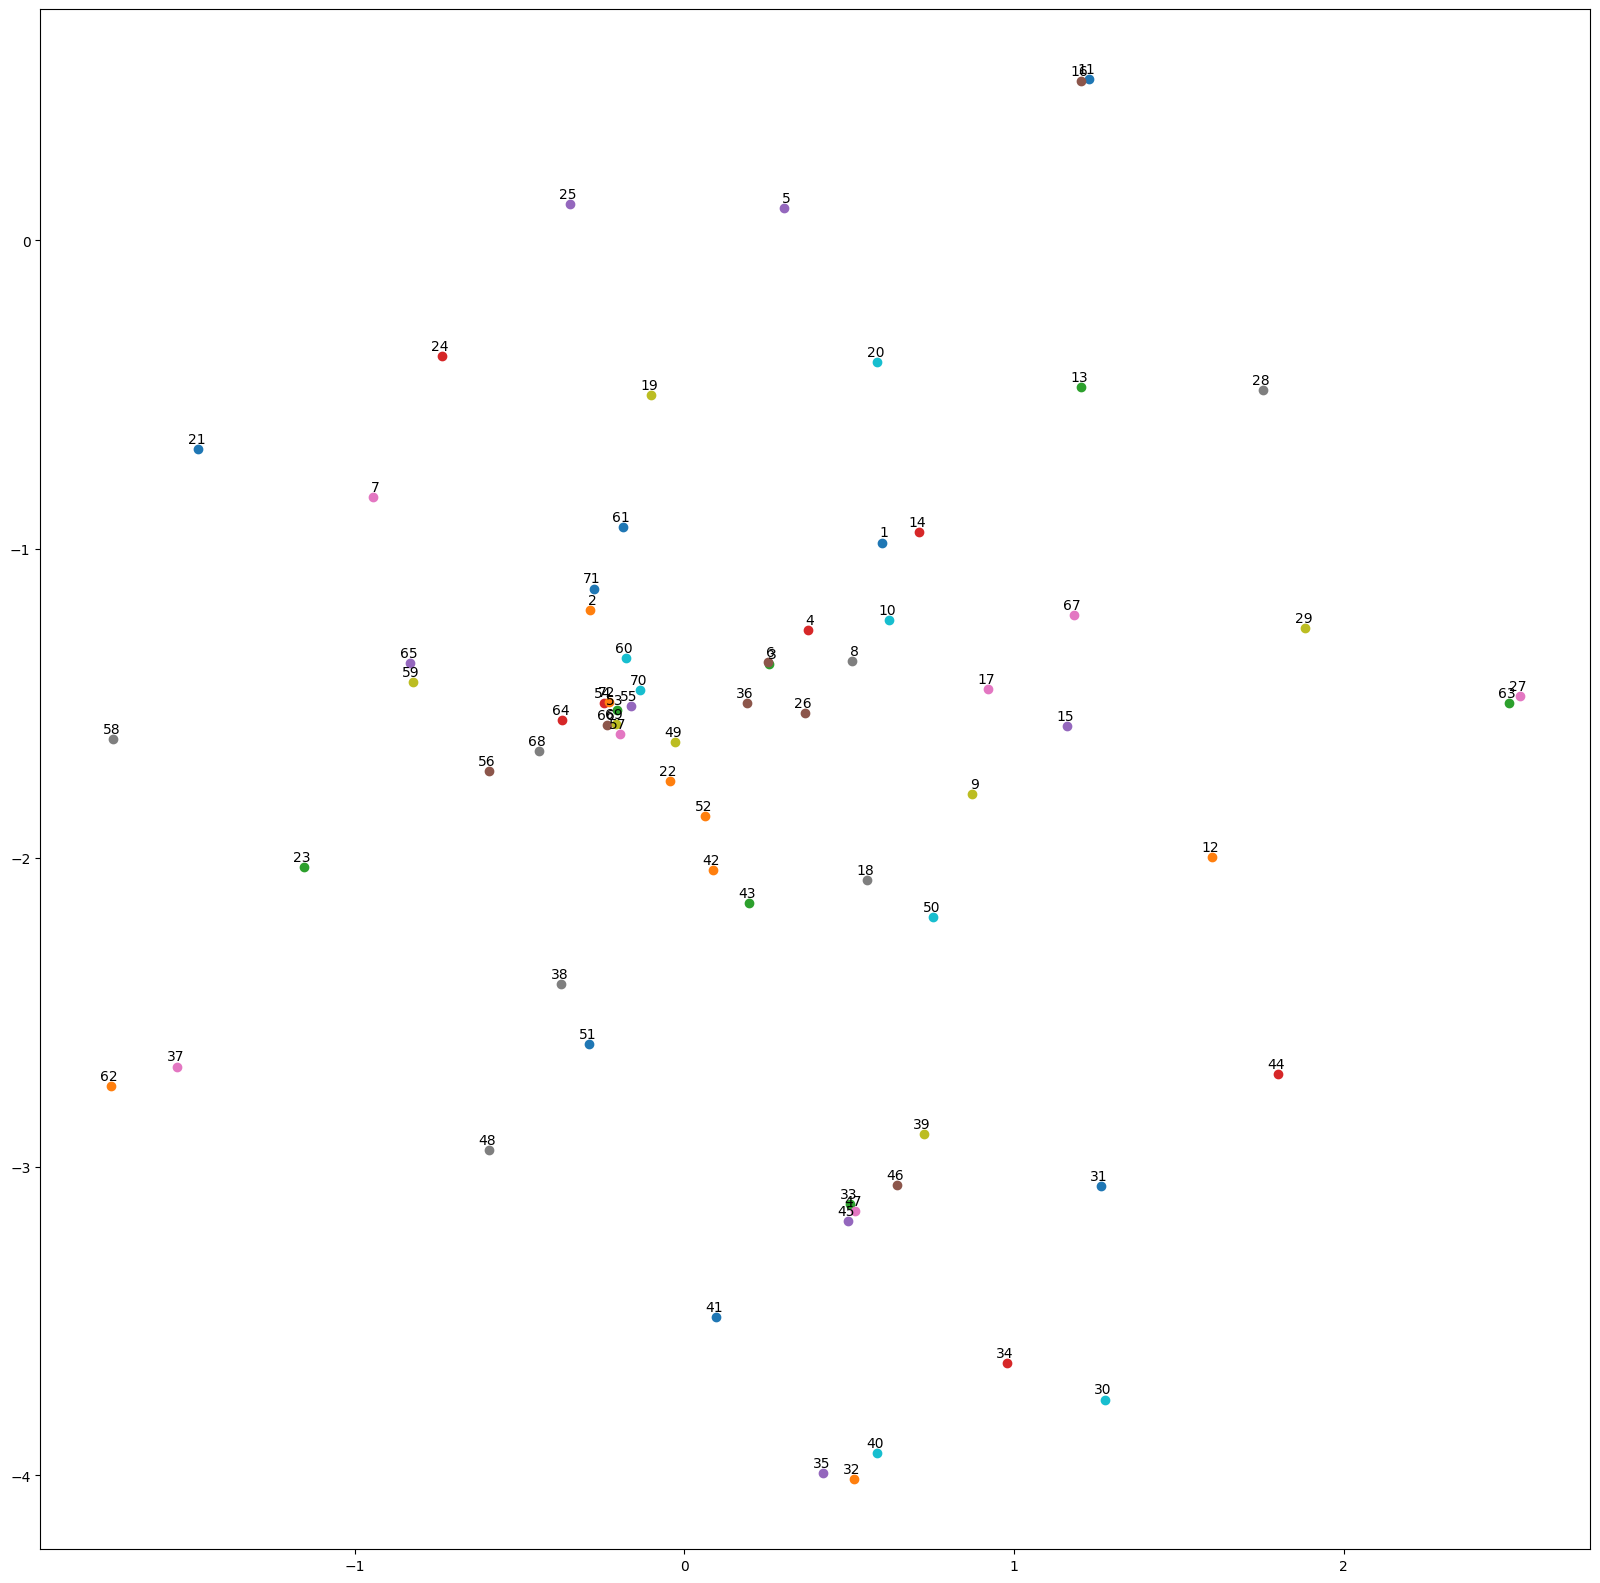

In [49]:
tsne_values = plot_documents(df)

Der DBSCAN

In [11]:
from sklearn.cluster import DBSCAN

def dbscan_draw(vectors, epsilon, min):
    dbscan = DBSCAN(eps=epsilon, min_samples=min)
    clusters = dbscan.fit_predict(vectors)
    plt.title("to the depths of depravity {} and the cusp of blasphemy {}.".format(epsilon, min))
    plt.scatter(vectors[:, 0], vectors[:, 1], c=clusters)
    plt.show()
    print(clusters)
    

Putting it all together in a function

In [12]:
# function takes a df from sql table (presumably) and spits out a DF with feature embeddings.

def ExtractFeatures(method, model, isWeighted=True, aggregateMethod="avg", epsilon=0.01, minsamp=2, topics=5):
    # initialize components that need to be initialized.

    # extract the dataset in df
    df = pd.read_excel("Dataset.xlsx")

    # preprocess each document
    preprocessed_docs = [preprocess_document(doc, isLemma=True, isStopwords=True) for doc in df["Answer"]]

    # prepare a word-set
    # my_word_set = get_word_set(df)
 
    # prepare TF-IDF matrix for weighted embedding or weighted LDA
    if isWeighted:
        my_tfidf, my_matrix = get_tfidf(preprocessed_docs)

    # choose feature extraction (embed or LDA)
    doc_embeds = []
    if method == "embed":
        word_embedded_docs = [word_embed(doc, model) for doc in preprocessed_docs] # word embedding
        # choose sentence embedding method here
        if isWeighted:
            doc_embeds = sentence_embed_weighted(word_embedded_docs, my_tfidf, aggregateMethod)
        else:
            doc_embeds = sentence_embed_unweighted(word_embedded_docs, aggregateMethod)
    elif method == "lda":
       doc_embeds = LDA(preprocessed_docs, topics)

    # append embedding to each document
    if doc_embeds:  
        df["Document Embed"] = doc_embeds
    
    # get reduced values and draw the thang
    tsne_values = plot_documents(df)
    dbscan_draw(tsne_values, epsilon, minsamp) 

    # # return the DF
    # return df
    

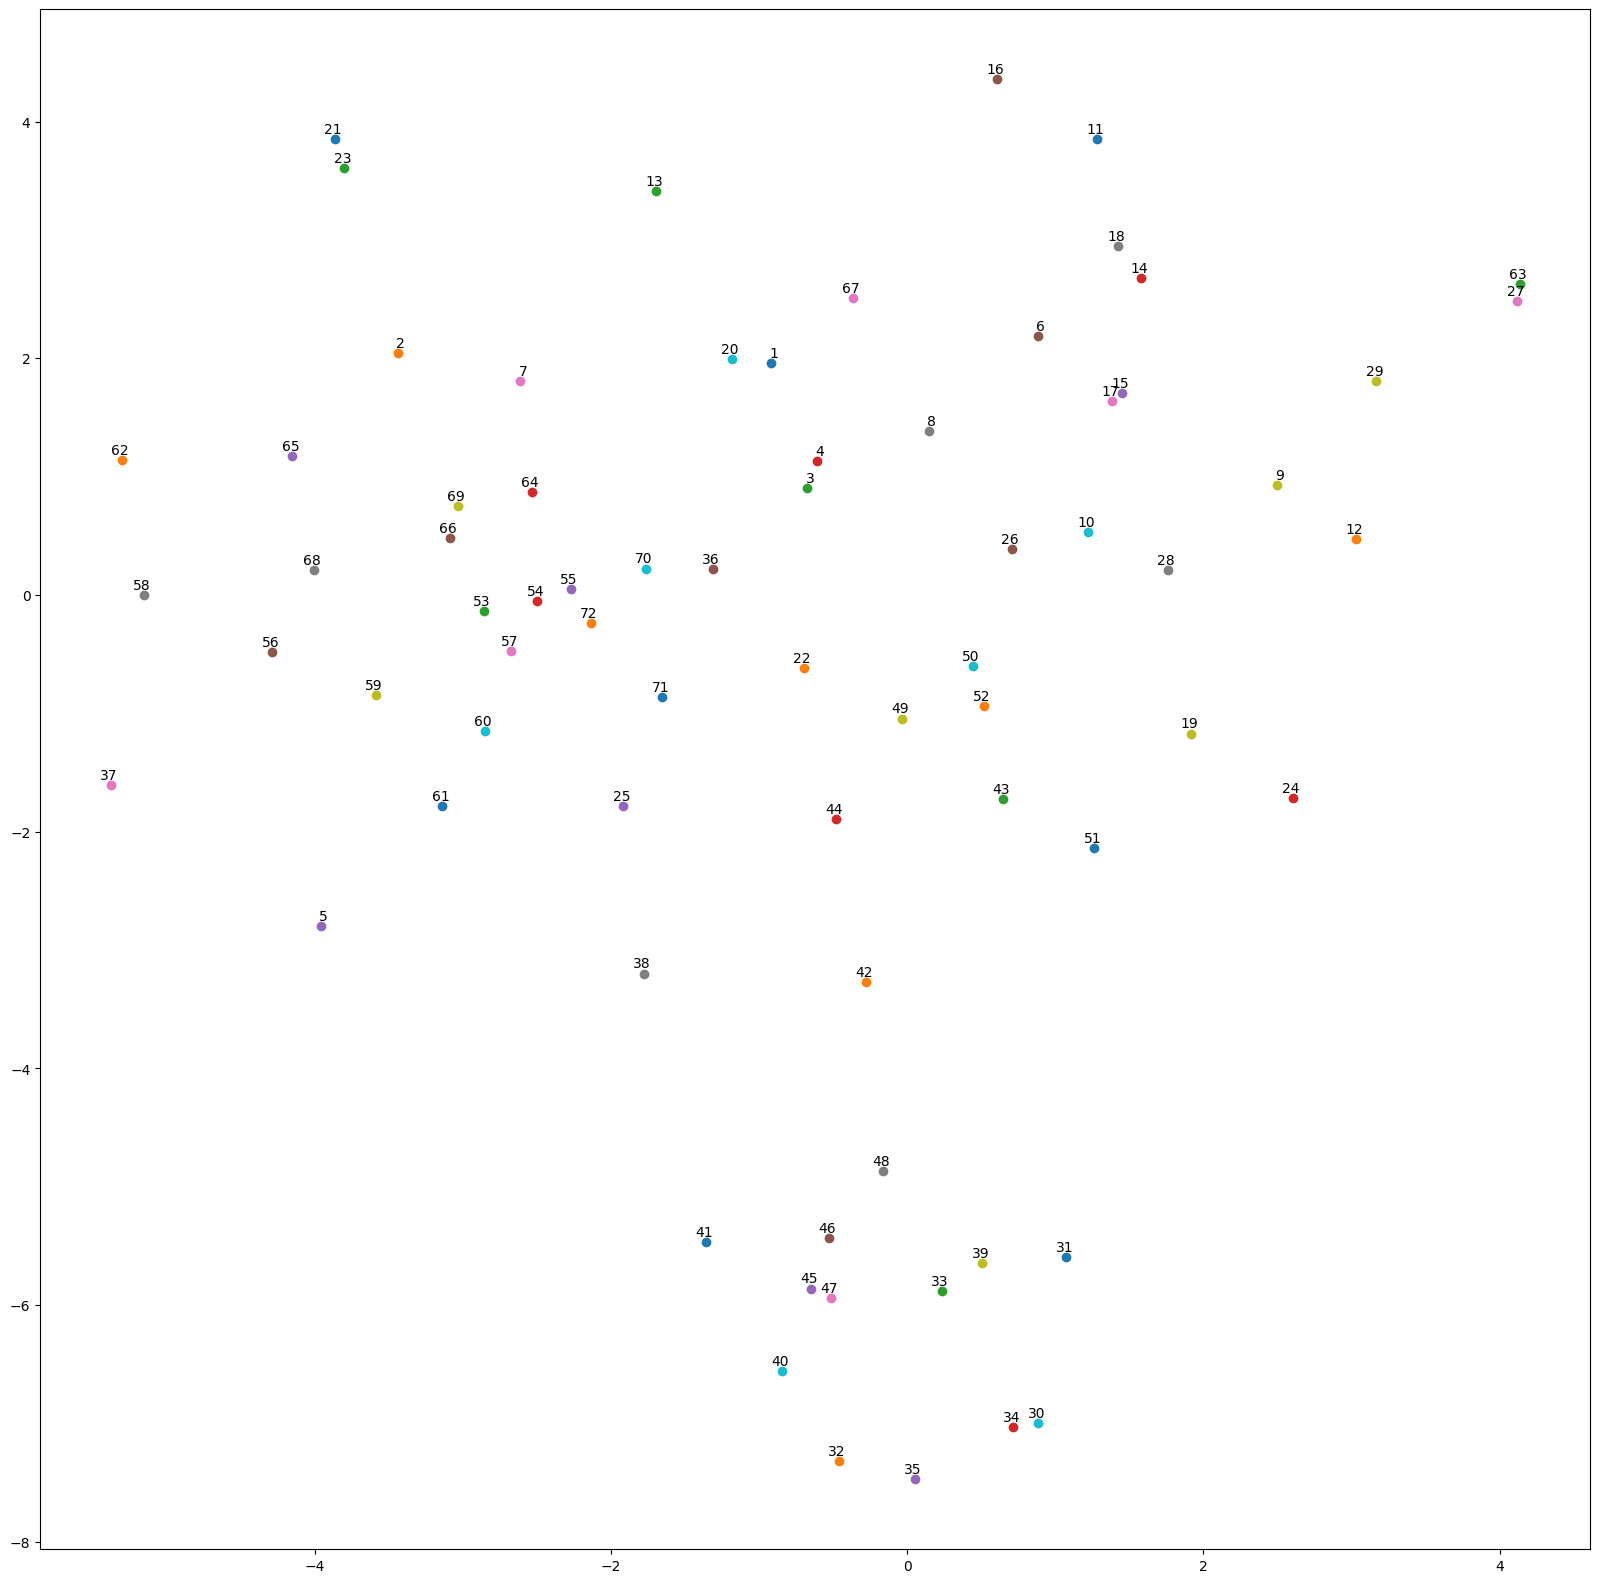

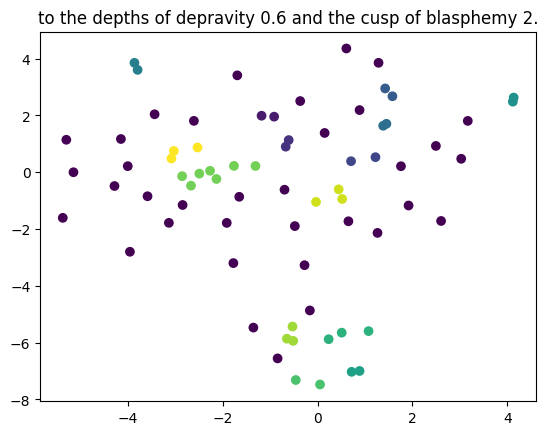

[ 0 -1  1  1 -1 -1 -1 -1 -1  2 -1 -1 -1  3  4 -1  4  3 -1  0  5 -1  5 -1
 -1  2  6 -1 -1  7  8  9  8  7  9 10 -1 -1  8 -1 -1 -1 -1 -1 11 11 11 -1
 12 12 -1 12 10 10 10 -1 10 -1 -1 -1 -1 -1  6 13 -1 13 -1 -1 13 10 -1 10]


In [24]:
ExtractFeatures("embed", model, isWeighted=False, aggregateMethod="avg", epsilon=0.6, minsamp=2) 

Invoke the functions here

In [ ]:
epsilonRange = np.arange(0.01, 5, 0.01)
minSampRange = np.arange(2, 5, 1)
topicRange = np.arange(5, 20, 1)
experimentParams = {
    "featureExtractionMethod" : ["embed", "lda"],
    "isWeighted" : [True, False],
    "aggregateMethod" : ["sum", "avg", "var"],
    "epsilon": epsilonRange,
    "minSamp" : minSampRange,
    "topic" : topicRange
}

def DoAll(params):
    for fa_method in params["featureExtractionMethod"]:
        if params["featureExtractionMethod"] == "embed":
            for aggregateMethod in params["aggregateMethod"]:
                for isWeight in params["isWeighted"]:
                    for epsilon in params["epsilon"]:
                        for minSamp in params["minSamp"]:
                            print(fa_method, model, isWeight, aggregateMethod, epsilon, minSamp)
                            ExtractFeatures(fa_method, model=model, isWeighted=isWeight, aggregateMethod=aggregateMethod, epsilon=epsilon, minsamp=minSamp)
        else:
            for topic in params["topic"]:
                for epsilon in params["epsilon"]:
                    for minSamp in params["minSamp"]:
                        print(fa_method, model, topic, epsilon, minSamp)
                        ExtractFeatures(fa_method, model=model, topics=topic, epsilon=epsilon, minsamp=minSamp)

DoAll(experimentParams)